Diego Toribio  
Professor Eilin Perez  
SS-322: History and Visuality  
Final Project

In [78]:
import ee
import geemap
from IPython.display import Image, HTML
from collections import OrderedDict

# Authenticate & initialize
ee.Authenticate()
ee.Initialize(project='toribiodiego-ece471')

### Load & Display Monterrey Boundary

Here we load the geoBoundaries ADM2 collection, filter to Monterrey, and display it on a map centered slightly south of the city.

In [64]:
# load and filter geoBoundaries for Monterrey
monterrey_geob = ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2') \
    .filter(ee.Filter.And(
        ee.Filter.eq('shapeGroup', 'MEX'),
        ee.Filter.eq('shapeName', 'Monterrey')
    ))

# center map slightly south of city
lat, lon = 25.6866, -100.3161
m = geemap.Map(center=[lat - 0.05, lon], zoom=11)

# display the red boundary
m.addLayer(
    monterrey_geob,
    {'color': 'red', 'fillColor': '00000000', 'width': 3},
    'monterrey boundary'
)
m.addLayerControl()
m

Map(center=[25.636599999999998, -100.3161], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

### ΔNDBI Growth Map

We calculate the Normalized Difference Built-up Index (NDBI) for two years (2003 and 2013) using the appropriate Landsat collection and bands, then subtract to get ΔNDBI. Masking out values below 0.05 highlights significant built-up expansion. Finally, we overlay this growth layer on the Monterrey municipal outline for spatial context.

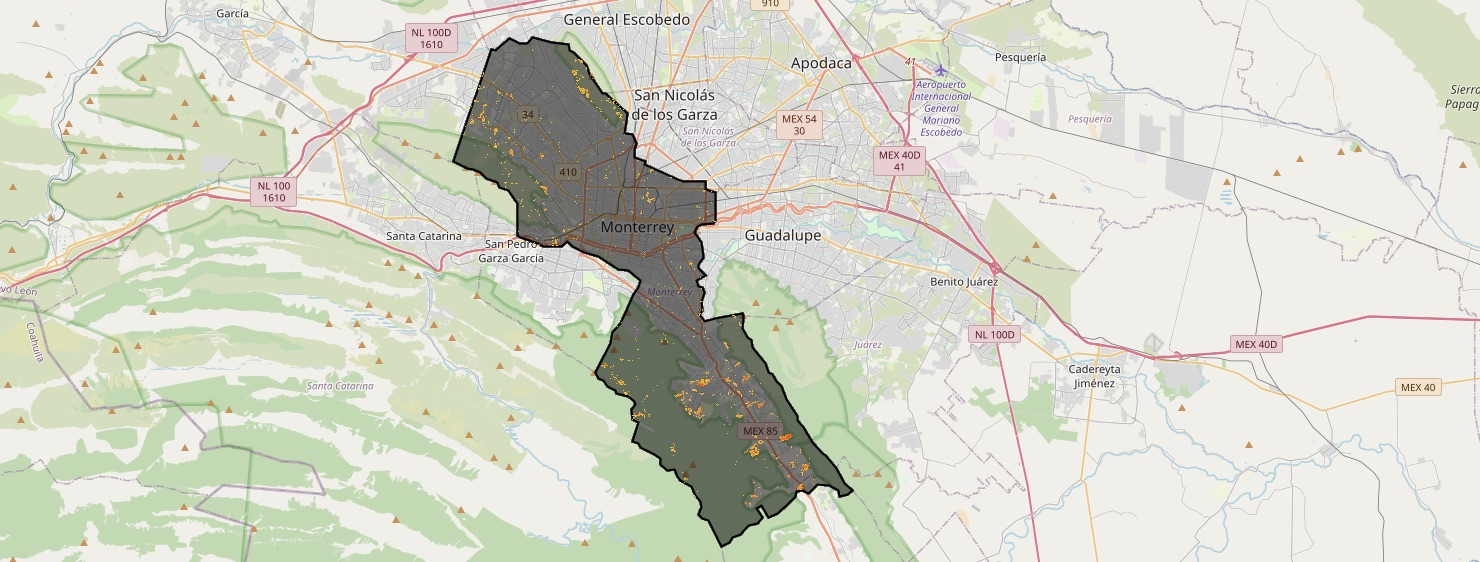

In [38]:
# load and filter Monterrey boundary
boundary_fc = (
    ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2')
      .filter(ee.Filter.And(
          ee.Filter.eq('shapeGroup', 'MEX'),
          ee.Filter.eq('shapeName', 'Monterrey')
      ))
)

# compute annual NDBI
def ndbi_year(year):
    coll = 'LANDSAT/LE07/C02/T1_L2' if year < 2013 else 'LANDSAT/LC08/C02/T1_L2'
    nir, swir = ('SR_B4','SR_B5') if year < 2013 else ('SR_B5','SR_B6')
    return (
        ee.ImageCollection(coll)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filterBounds(boundary_fc.geometry())
          .median()
          .clip(boundary_fc.geometry())
          .normalizedDifference([swir, nir])
          .rename('NDBI')
    )

ndbi03 = ndbi_year(2003)
ndbi13 = ndbi_year(2013)
growth = ndbi13.subtract(ndbi03).rename('ΔNDBI')

# visualization parameters
vis_growth = {
    'min': 0,
    'max': 0.3,
    'palette': ['#f0ff1e', '#f78d08', '#f71d06', '#110cff']
}

# display outline and growth
m = geemap.Map(center=[25.635, -100.3161], zoom=11)
m.addLayer(
    boundary_fc,
    {'color': 'black', 'fillColor': '#00000000', 'width': 2, 'fillOpacity': 0},
    'Monterrey Outline'
)
m.addLayer(
    growth.updateMask(growth.gt(0.05)),
    vis_growth,
    'Growth 2003 → 2013'
)
m.addLayerControl()
m

Image(filename='growth_map.jpeg')

### 5-Year ΔNDBI GIF (2000-2025)

Compute ΔNDBI over 5-year steps, blend with the Monterrey outline, and render as an animated GIF.


In [81]:
# compute median NDBI for a year
def compute_ndbi_year(boundary_fc, year):
    coll = 'LANDSAT/LE07/C02/T1_L2' if year < 2013 else 'LANDSAT/LC08/C02/T1_L2'
    nir, swir = ('SR_B4','SR_B5') if year < 2013 else ('SR_B5','SR_B6')
    img = (ee.ImageCollection(coll)
           .filterDate(f'{year}-01-01', f'{year}-12-31')
           .filterBounds(boundary_fc.geometry())
           .median()
           .clip(boundary_fc.geometry()))
    return img.normalizedDifference([swir, nir]).rename('NDBI')

# generate ΔNDBI frames for each interval
def compute_growth_frames(boundary_fc, start_year, end_year,
                          interval=5, threshold=0.05, vis_params=None,
                          boundary_color='ffffff', boundary_width=2):
    if vis_params is None:
        vis_params = {
            'min': 0, 'max': 0.3,
            'palette': ['#f0ff1e','#f78d08','#f71d06','#110cff']
        }
    # outline image
    b_img = ee.Image().byte().paint(boundary_fc, 1, boundary_width)
    b_rgb = b_img.visualize(palette=[boundary_color], forceRgbOutput=True)
    frames = OrderedDict()
    years = list(range(start_year, end_year+1, interval))
    for s in years[:-1]:
        e = s + interval
        diff = compute_ndbi_year(boundary_fc, e) \
               .subtract(compute_ndbi_year(boundary_fc, s)) \
               .rename('ΔNDBI')
        diff = diff.updateMask(diff.gt(threshold)) \
                   .set('system:time_start', ee.Date.fromYMD(e,1,1).millis())
        growth_rgb = diff.visualize(**vis_params)
        frame = growth_rgb.blend(b_rgb) \
                   .set('system:time_start', diff.get('system:time_start'))
        frames[e] = frame
    return frames

# create GIF URL from frames
def make_gif_url(frames_dict, region, fps=1, dimensions=600):
    """
    Stitch pre‐rendered RGB frames into a hosted GIF URL,
    dropping any stray non‐RGB bands.
    """
    # 1. Take the values (the ee.Image frames), not the keys!
    imgs = list(frames_dict.values())
    ic = ee.ImageCollection(imgs)
    # 2. Select only the 3 RGB bands produced by visualize()
    ic_rgb = ic.select(['vis-red', 'vis-green', 'vis-blue'])
    # 3. Generate the GIF
    return ic_rgb.getVideoThumbURL({
        'framesPerSecond': fps,
        'dimensions':     dimensions,
        'region':         region,
        'format':         'gif'
    })


# render animated GIF with year label
def get_gif(frames_dict, gif_url, fps=1, dimensions=600,
            title="Urban Growth (ΔNDBI)", max_width=600):
    years = list(frames_dict.keys())
    n, duration = len(years), len(years)/fps
    kf = []
    for i, yr in enumerate(years):
        p0, p1 = (i/n)*100, ((i+1)/n)*100
        kf += [f"  {p0:.2f}% {{ content: '{yr}'; }}",
               f"  {p1:.2f}% {{ content: '{yr}'; }}"]
    keyframes = "\n".join(kf)
    html = f"""
<div style="text-align:center;margin-top:20px">
  <h3>{title}</h3>
  <div style="position:relative;display:inline-block;max-width:{max_width}px;width:100%">
    <img src="{gif_url}" style="width:100%;height:auto" alt="ΔNDBI GIF"/>
    <div class="yearLabel" style="position:absolute;top:8px;right:12px;
          font-family:sans-serif;font-size:20px;font-weight:bold;
          color:#fff;text-shadow:1px 1px 3px rgba(0,0,0,0.7)"></div>
  </div>
</div>
<style>
@keyframes yearAnim {{
{keyframes}
}}
.yearLabel::after {{
  content:'{years[0]}';
  animation:yearAnim {duration}s steps({n}) infinite;
}}
</style>
"""
    return HTML(html)


# define boundary and build GIF
boundary_fc = ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2') \
    .filter(ee.Filter.And(
        ee.Filter.eq('shapeGroup','MEX'),
        ee.Filter.eq('shapeName','Monterrey')
    ))
frames_dict = compute_growth_frames(boundary_fc, 2000, 2025, interval=5)
gif_url = make_gif_url(frames_dict.values(), boundary_fc.geometry())
display(get_gif(frames_dict, gif_url,
                fps=1, dimensions=600,
                title="Monterrey 5-Year Urban Growth (ΔNDBI)",
                max_width=600))

### Annual ΔNDBI GIF (2015–2025)

Compute yearly ΔNDBI frames, build gif url, and render animated map with year overlay.


In [88]:
# generate annual growth frames
frames_dict = compute_growth_frames(boundary_fc, 2015, 2025, interval=1)

# create gif url
gif_url = make_gif_url(
    frames_dict,
    region=boundary_fc.geometry(),
    fps=1,
    dimensions=600
)

# display animated growth
display(get_gif(
    frames_dict,
    gif_url,
    fps=1,
    dimensions=600,
    title="Monterrey Annual Urban Growth (ΔNDBI): 2015–2025",
    max_width=600
))